In [8]:
!nvidia-smi

Mon Jan 26 18:30:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
!pip install -q ultralytics roboflow opencv-python matplotlib seaborn pyyaml

In [10]:
import os
import glob
import yaml
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from roboflow import Roboflow

rf = Roboflow(api_key="2hHNdIQGbzDmN5Uw76QJ")

project = rf.workspace("xray-u9rf3").project("wsiroisimages")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [12]:
yaml_path = glob.glob("**/data.yaml", recursive=True)[0]
print("Found data.yaml at:", yaml_path)

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

print("Classes:", data["names"])
print("Number of classes:", data["nc"])

Found data.yaml at: wsiroisImages-1/data.yaml
Classes: ['lymphocytes and plasma cells']
Number of classes: 1


In [14]:
dataset_root = os.path.dirname(yaml_path)

for split in ["train", "valid", "test"]:
    img_dir = os.path.join(dataset_root, split, "images")
    lbl_dir = os.path.join(dataset_root, split, "labels")

    print(f"\n{split.upper()} SET")
    if os.path.isdir(img_dir):
        print("Images:", len(os.listdir(img_dir)))
    else:
        print(f"Images: Not found (Directory '{img_dir}' does not exist or is empty)")

    if os.path.isdir(lbl_dir):
        print("Labels:", len(os.listdir(lbl_dir)))
    else:
        print(f"Labels: Not found (Directory '{lbl_dir}' does not exist or is empty)")


TRAIN SET
Images: 1503
Labels: 1503

VALID SET
Images: 376
Labels: 376

TEST SET
Images: Not found (Directory 'wsiroisImages-1/test/images' does not exist or is empty)
Labels: Not found (Directory 'wsiroisImages-1/test/labels' does not exist or is empty)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

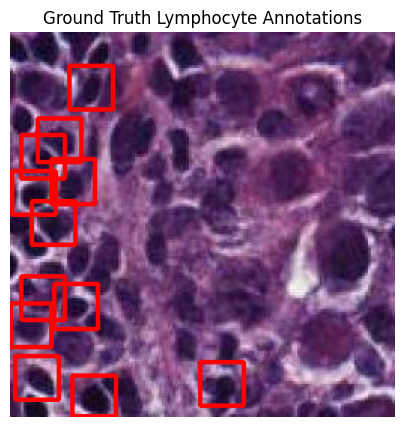

In [15]:
img_dir = os.path.join(dataset_root, "train/images")
lbl_dir = os.path.join(dataset_root, "train/labels")

img_name = random.choice(os.listdir(img_dir))
img_path = os.path.join(img_dir, img_name)
lbl_path = os.path.join(lbl_dir, img_name.replace(".jpg", ".txt"))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

with open(lbl_path) as f:
    for line in f:
        cls, x, y, bw, bh = map(float, line.split())
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Ground Truth Lymphocyte Annotations")
plt.axis("off")

In [16]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
print("YOLOv8 model loaded successfully")

YOLOv8 model loaded successfully


In [17]:
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    lr0=1e-3,
    patience=10,
    device=0,
    project="TIL_Project",
    name="YOLOv8_TIL_Detection"
)

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=wsiroisImages-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=YOLOv8_TIL_Detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0.0, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b1205c09a30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [19]:
metrics = model.val()

print(f"Precision      : {metrics.box.mp:.3f}")
print(f"Recall         : {metrics.box.mr:.3f}")
print(f"mAP@0.5        : {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95   : {metrics.box.map:.3f}")

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 686.7±310.7 MB/s, size: 14.9 KB)
val: Scanning /content/wsiroisImages-1/valid/labels.cache... 376 images, 146 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 376/376 175.2Mit/s 0.0s
val: /content/wsiroisImages-1/valid/images/TC_S01_P000113_C0001_B101_-33354-86458-34598-87564-_png.rf.0d753e9a144f7988bef3c5da25c3fedd.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 2.9it/s 8.2s
                   all        376       6661      0.675       0.62      0.675      0.428
Speed: 2.3ms preprocess, 4.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /content/runs/detect/val2
Precision      : 0.675
Recall         : 0.620
mAP@0.5        : 0.675
mAP@0.5:0.95   : 0.428


(np.float64(-0.5), np.float64(2399.5), np.float64(1199.5), np.float64(-0.5))

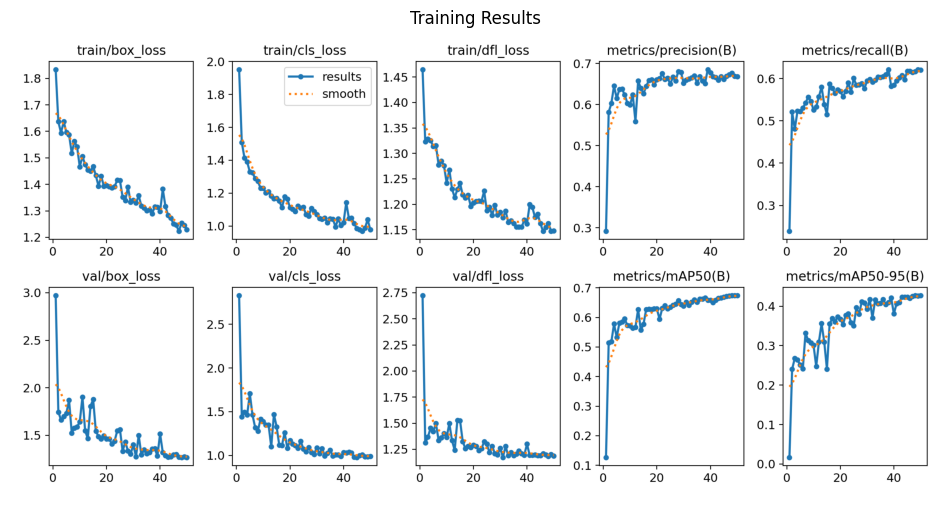

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

results_img = Image.open("runs/detect/TIL_Project/YOLOv8_TIL_Detection/results.png")

plt.figure(figsize=(12,8))
plt.imshow(results_img)
plt.title("Training Results")
plt.axis("off")

In [23]:
results = model.predict(
    source=os.path.join(dataset_root, "valid/images"),
    conf=0.25,
    save=True
)


image 1/376 /content/wsiroisImages-1/valid/images/100B_-35129-6567-36429-7757-_png.rf.a26ea795974dd0c1163a4030db4c0eb0.jpg: 640x640 17 lymphocytes and plasma cellss, 8.0ms
image 2/376 /content/wsiroisImages-1/valid/images/134B_-52914-12263-54149-13444-_png.rf.e8fe08ff6cb9f97f3ca65afbf1de5397.jpg: 640x640 51 lymphocytes and plasma cellss, 7.3ms
image 3/376 /content/wsiroisImages-1/valid/images/136B_-73791-8482-75066-9666-_png.rf.29577c350bb72a83e5ffab52e731648f.jpg: 640x640 5 lymphocytes and plasma cellss, 7.2ms
image 4/376 /content/wsiroisImages-1/valid/images/154B_-2199-20514-3357-21703-_png.rf.979afcfb4e96071f0d22c8c281bf7c09.jpg: 640x640 14 lymphocytes and plasma cellss, 7.2ms
image 5/376 /content/wsiroisImages-1/valid/images/181S_-34272-32152-35623-33367-_png.rf.81fad14b01921f6438f35341683677d3.jpg: 640x640 6 lymphocytes and plasma cellss, 9.3ms
image 6/376 /content/wsiroisImages-1/valid/images/196S_-7964-15811-9098-16894-_png.rf.38389b4e867383f829a2aa6bc5c3fffd.jpg: 640x640 (no d

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

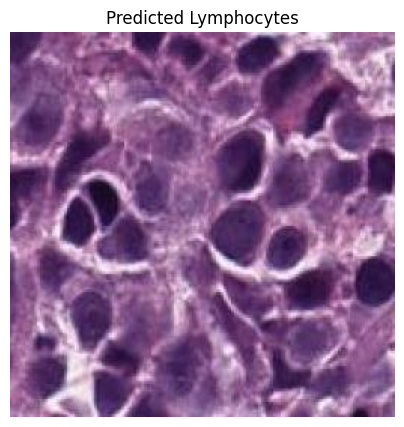

In [24]:
pred_dir = "runs/detect/predict"
sample = random.choice(os.listdir(pred_dir))

img = cv2.imread(os.path.join(pred_dir, sample))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Predicted Lymphocytes")
plt.axis("off")

In [25]:
cell_counts = [len(r.boxes) for r in results]

print("Average lymphocytes per image:", sum(cell_counts)/len(cell_counts))
print("Maximum lymphocytes in an image:", max(cell_counts))

Average lymphocytes per image: 16.590425531914892
Maximum lymphocytes in an image: 300


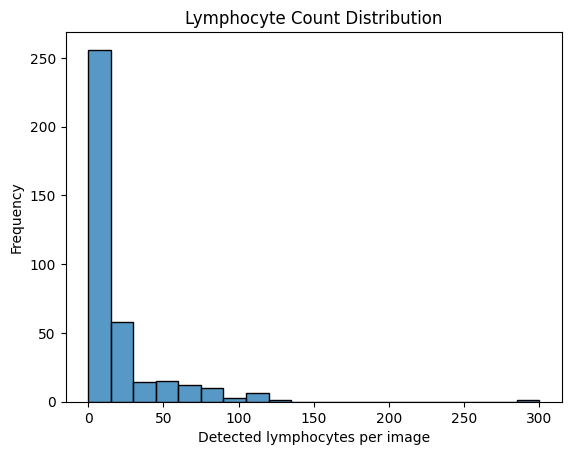

In [26]:
sns.histplot(cell_counts, bins=20)
plt.xlabel("Detected lymphocytes per image")
plt.ylabel("Frequency")
plt.title("Lymphocyte Count Distribution")
plt.show()

In [27]:
import numpy as np

til_densities = []

for r in results:
    img_h, img_w = r.orig_shape
    tissue_area = img_h * img_w
    lymphocyte_count = len(r.boxes)

    density = lymphocyte_count / tissue_area
    til_densities.append(density)

print("Average TIL density:", np.mean(til_densities))
print("Max TIL density:", np.max(til_densities))

Average TIL density: 0.0002531498036486037
Max TIL density: 0.00457763671875


In [28]:
def til_score(density):
    if density < 1e-6:
        return 0   # Low TILs
    elif density < 3e-6:
        return 1   # Moderate-low
    elif density < 6e-6:
        return 2   # Moderate-high
    else:
        return 3   # High TILs

til_scores = [til_score(d) for d in til_densities]

print("TIL score distribution:", {i: til_scores.count(i) for i in range(4)})

TIL score distribution: {0: 109, 1: 0, 2: 0, 3: 267}


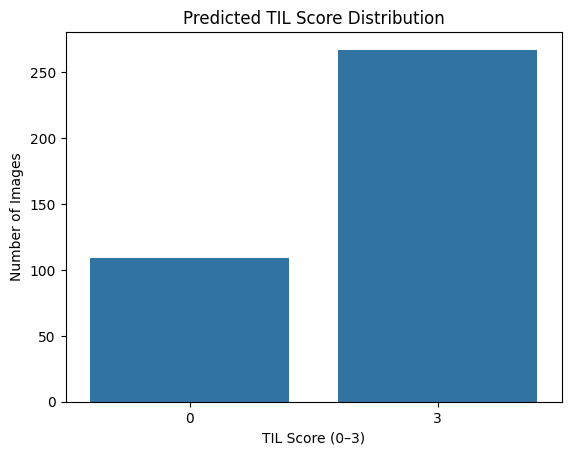

In [29]:
sns.countplot(x=til_scores)
plt.xlabel("TIL Score (0–3)")
plt.ylabel("Number of Images")
plt.title("Predicted TIL Score Distribution")
plt.show()

In [30]:
import torch
from ultralytics.utils.torch_utils import select_device

device = select_device("0")
model.model.to(device)
model.model.eval()

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(32

In [34]:
import torch.nn.functional as F

def generate_activation_map(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (640, 640))

    img_tensor = torch.from_numpy(img_resized).float().permute(2,0,1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)

    # List to store the features from the target layer
    captured_features = []

    def hook_fn(module, input, output):
        # Store the output of the module
        captured_features.append(output)

    # Register a forward hook on the target layer (model.model.model[-2])
    # This layer is a C2f block in the neck, which is good for activation maps.
    hook = model.model.model[-2].register_forward_hook(hook_fn)

    # Perform a full forward pass through the model
    # Using model.predict to ensure the whole pipeline is run, but we don't need the results here.
    _ = model.predict(source=img_tensor, verbose=False, device=device)

    # Remove the hook after capturing features
    hook.remove()

    # Get the captured features (should be one item in the list)
    if not captured_features:
        raise RuntimeError("No features were captured. Ensure the model's forward pass was executed.")

    feats = captured_features[0]

    # Generate the heatmap from the features
    # Reduce the features along the channel dimension (dim=1) by taking their mean
    heatmap = feats.mean(dim=1).squeeze().cpu().numpy()

    # Resize the heatmap to the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize the heatmap to a 0-1 range
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8) # Add epsilon to avoid division by zero

    return img, heatmap

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

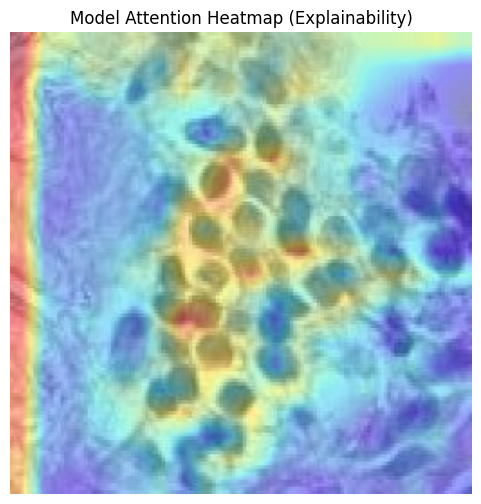

In [35]:
sample_img = random.choice(os.listdir(os.path.join(dataset_root, "valid/images")))
img_path = os.path.join(dataset_root, "valid/images", sample_img)

img, heatmap = generate_activation_map(model, img_path)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.title("Model Attention Heatmap (Explainability)")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

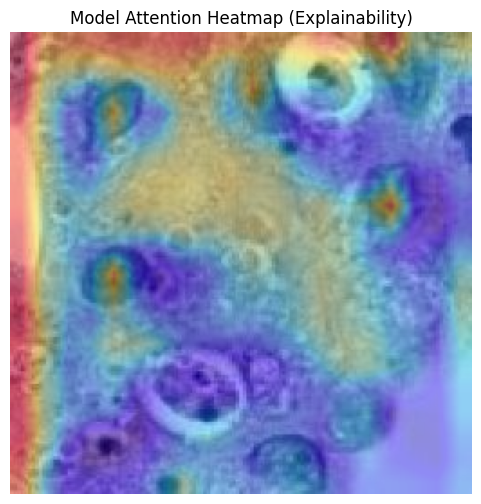

In [36]:
sample_img = random.choice(os.listdir(os.path.join(dataset_root, "valid/images")))
img_path = os.path.join(dataset_root, "valid/images", sample_img)

img, heatmap = generate_activation_map(model, img_path)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.title("Model Attention Heatmap (Explainability)")
plt.axis("off")

In [37]:
print("Pipeline Summary")
print("----------------")
print(f"Total test images evaluated: {len(results)}")
print(f"Mean TIL density: {np.mean(til_densities):.2e}")
print(f"Most common TIL score: {max(set(til_scores), key=til_scores.count)}")

Pipeline Summary
----------------
Total test images evaluated: 376
Mean TIL density: 2.53e-04
Most common TIL score: 3
